In [2]:
"""
Created on Sat Nov 30 13:36:16 2019

@author: Talha Ilyas
"""
# Import necessary libraries
import idx2numpy
import numpy
import time, sys
import matplotlib.pyplot as plt
import scipy.special
from tqdm import trange

In [3]:
class CNN:
    # initialise the neural network
    def __init__(self, filter_1, filter_2, h1nodes, h2nodes, opnodes, bias_hid2op, bias_hid1hid2, bias_iphid1, momentum, BatchSize, learningrate, decay):
        '''
        Parameters
        ----------
        filter_1 : filter size for 1st conv layer [type = tuple] e.g. ->  (5,5)
        filter_2 : filter size for 2nd conv layer [type = tuple] e.g. ->  (5,5)
        input_nodes : Number of nodes in 1st hidden layer [type = int] e.g. -> 200
        h1nodes : Number of nodes in 2nd hidden layer [type = int] e.g. -> 200
        h2nodes : Number of nodes in 3rd hidden layer [type = int] e.g. -> 200
        opnodes : Number of nodes in ouput layer [type = int] equal to number of classes;
                  in case of CIFAR-10 and MNIST -> 10
        bias_hid2op : bias vector len. equal to output_nodes
        bias_hid1hid2 : bias vector len. equal to nodes_in_2nd_hidden_layer
        bias_iphid1 : bias vector len. equal to nodes_in_1st_hidden_layer
        momentum : a hyperparameter for gradient descent [type = float] e.g. ->  0.9
        BatchSize : for how many times to iterate over whole data [type = int] e.g. ->  50
        learningrate : a hyperparameter for gradient descent [type = float] e.g. ->  0.01
        decay : a hyperparameter for learning rate decay [type = float] e.g. ->  0.0001

        Returns
        -------
        None.

        '''
        # set number of nodes in each input, hidden, output layer
        #Two Conv Filters
        self.filter1_h, self.filter1_w = filter_1
        self.filter2_h, self.filter2_w = filter_2

        self.ip_nodes = 16
        self.h1_nodes = h1nodes
        self.h2_nodes = h2nodes
        self.op_nodes = opnodes

        self.bias_h2op = bias_hid2op
        self.bias_h1h2 = bias_hid1hid2
        self.bias_iph1 = bias_iphid1
        
        self.batch_size = BatchSize
        #Momentum
        self.beta = momentum
        
        self.Vdw_h2_op = 0
        self.Vdw_h1_h2 = 0
        self.Vdw_ip_h1 = 0
        
        self.Vdb_h2_op = 0
        self.Vdb_h1_h2 = 0
        self.Vdb_ip_h1 = 0

        #Guassian Normal Distribution pow() means deviation in values is between +- h2_nodes**-0.5 with mean=0
        self.w_c1 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(self.filter1_h, self.filter1_w))
        self.w_c2 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(self.filter2_h, self.filter2_w))
        # Linking weights
        #Guassian Normal Distribution pow() means deviation in values is between +- h2_nodes**-0.5 with mean=0
        self.w_ip_h1 = numpy.random.normal(0.0, pow(self.h1_nodes, -0.5),(self.h1_nodes, self.ip_nodes))
        self.w_h1_h2 = numpy.random.normal(0.0, pow(self.h2_nodes, -0.5),(self.h2_nodes, self.h1_nodes))
        self.w_h2_op = numpy.random.normal(0.0, pow(self.op_nodes, -0.5),(self.op_nodes, self.h2_nodes))
        #Linking Biases
        #Guassian Normal Distribution pow() means deviation in values is between +- h2_nodes**-0.5 with mean=0
        self.bias_h2_op = numpy.random.normal(0.0, pow(self.bias_h2op, -0.5),(self.bias_h2op, 1))
        self.bias_h1_h2 = numpy.random.normal(0.0, pow(self.bias_h1h2, -0.5),(self.bias_h1h2, 1))
        self.bias_ip_h1 = numpy.random.normal(0.0, pow(self.bias_iph1, -0.5),(self.bias_iph1, 1))
        
        # learning rate
        self.lr = learningrate
        self.lr_decay = decay
        
        # activation function is the sigmoid function
        self.Sigm = lambda x: scipy.special.expit(x)
        pass
     #--------------------------Derivative of Activation Functions----------------------------
    def d_Sigm(self,x):
        self.x = x * (1 - x)
        return self.x
    #---------------Single Layer/channel  Conv 1st filter----------------------------------------------------
    def sc_conv(self, image, flter):
        X = flter
        Y = image
        k,l=X.shape
        i,j=Y.shape
        Op = numpy.zeros((i-k+1,i-k+1))
        for b in range(j-l+1): 
            for a in range(i-k+1):
                Op[b,a] = numpy.sum(numpy.multiply(X,Y[b:k+b,a:a+k]),axis=(0,1))
        return Op
    #---------------Single filter pooling---------------------------------
    def sf_pooling(self, Op):
        op = Op
        c,d = op.shape
        e = c-c//2
        pool = numpy.zeros((e,e))
        locations = numpy.zeros((e,e))
        for g in range(c-e):
            for f in range(c-e):
                pool[g,f] = numpy.max(op[g*2:g+g+2,f*2:f+f+2])
                locations[g,f] = numpy.argmax(Op[g*2:g+g+2,f*2:f+f+2])
        return locations,pool
    #------------------------Back Pool Single Layer/Channel---------------------------
    def b_sf_pooling(self, before_pooling_shape,locations,pool_values):
        cache1 = pool_values
        cache2 = before_pooling_shape.shape
        cache3 = locations.astype(int)
        b_Op = numpy.zeros(cache2)
        t,u = cache1.shape
        for j in range(u):
            for i in range(t):
               a = cache3[j,i]
               numpy.put(b_Op[j*2:j+j+2,i*2:i+i+2],a, cache1[j,i])
        return b_Op
    #------------------------Back Conv Single Layer/Channel---------------------------
    def b_sc_conv(self, b_pool_op, image):  
        X = b_pool_op
        Y = image
        k,l=X.shape
        i,j=Y.shape
        f_g = numpy.zeros((i-k+1,i-k+1))
        for b in range(j-l+1):
            for a in range(i-k+1):
                f_g[b,a] = numpy.sum(numpy.multiply(X,Y[b:k+b,a:a+k]),axis=(0,1))
        return f_g
    #------------------------------------------------------------ Train the CNN------------------------------------
    def train(self, inputs_list, targets_list,iteration,epoch):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2)
        targets = numpy.array(targets_list, ndmin=2)
        t = iteration
        #e = epoch
        #--------------Learning Rate Decay--------------------
        lr = self.lr
        lr *=  (1. / (1. + (self.lr_decay * t)))
        #------Conv 1 ------
        conv1_op = self.sc_conv(inputs,self.w_c1)
        #------activate----
        conv1_opA = self.Sigm(conv1_op)
        #------Pool 1------
        locations1,pool1_op = self.sf_pooling(conv1_opA)
        
        #---------Conve 2-----
        conv2_op = self.sc_conv(pool1_op,self.w_c2)
        #-----Activate------
        conv2_opA = self.Sigm(conv2_op)
        #-----Pool 2------
        locations2,pool2_op = self.sf_pooling(conv2_opA)
        #-----Flattening----------
        t = pool2_op.flatten()
        CNN_op = t.reshape(16,1)
        
        X_h1 = numpy.add(numpy.dot(self.w_ip_h1, CNN_op) , self.bias_ip_h1)
        O_h1 = self.Sigm(X_h1)
        # calculate signals into hidden layer
        X_h2 = numpy.add(numpy.dot(self.w_h1_h2, O_h1) , self.bias_h1_h2)
        O_h2 = self.Sigm(X_h2)
        # calculate signals into final output layer
        X_op = numpy.add(numpy.dot(self.w_h2_op, O_h2) , self.bias_h2_op)
        O_op = self.Sigm(X_op)
        # output layer error is the (target - actual)
        errors_op = targets - O_op
        errors_h2 = numpy.dot(self.w_h2_op.T, errors_op)
        errors_h1 = numpy.dot(self.w_h1_h2.T, errors_h2)
        errors_ip = numpy.dot(self.w_ip_h1.T, errors_h1)
        errors_ipR = errors_ip.reshape(4,4)
        #errors_ipR = numpy.rot90(errors_ipR,k=2)
        
        errors_ipRB = self.b_sf_pooling(conv2_op, locations2, errors_ipR)
        errors_c2 = errors_ipRB
        errors_c2P = numpy.pad(errors_c2,(4,4),'constant', constant_values=(0))
        w_c2F = numpy.rot90(self.w_c2,k=2)
        errors_c1 = self.sc_conv(errors_c2P, w_c2F)
        #errors_c1 = numpy.rot90(errors_c1,k=2)
        errors_c1B = self.b_sf_pooling(conv1_op, locations1, errors_c1)
        #errors_c1B = numpy.rot90(errors_c1B, k=2)
        
        self.dw_h2_op = numpy.dot((errors_op * self.d_Sigm(O_op)), numpy.transpose(O_h2))
        self.dw_h1_h2 = numpy.dot((errors_h2 * self.d_Sigm(O_h2)), numpy.transpose(O_h1))
        self.dw_ip_h1 = numpy.dot((errors_h1 * self.d_Sigm(O_h1)), numpy.transpose(CNN_op))
        #For Biases
        self.db_h2_op = (numpy.sum(errors_op *self.d_Sigm(O_op))) / self.batch_size
        self.db_h1_h2 = (numpy.sum(errors_h2 *self.d_Sigm(O_h2))) / self.batch_size
        self.db_ip_h1 = (numpy.sum(errors_h1 *self.d_Sigm(O_h1))) / self.batch_size
        
        self.Vdw_h2_op =  beta*self.Vdw_h2_op +(1-beta)*self.dw_h2_op
        self.Vdw_h1_h2 =  beta*self.Vdw_h1_h2 +(1-beta)*self.dw_h1_h2
        self.Vdw_ip_h1 =  beta*self.Vdw_ip_h1 +(1-beta)*self.dw_ip_h1
        
        self.Vdb_h2_op =  beta*self.Vdb_h2_op +(1-beta)*self.db_h2_op
        self.Vdb_h1_h2 =  beta*self.Vdb_h1_h2 +(1-beta)*self.db_h1_h2
        self.Vdb_ip_h1 =  beta*self.Vdb_ip_h1 +(1-beta)*self.db_ip_h1
        #------Back Conv----------------------------------------------------------------MayBe---------------------------------------------
        f_g2 = errors_c2 * self.d_Sigm(conv2_opA)
        f_g1 = errors_c1B * self.d_Sigm(conv1_opA)
        f_grad2 = self.b_sc_conv(f_g2, pool1_op)
        f_grad1 = self.b_sc_conv(f_g1, inputs)
        
        #--------------------------------------------------------------------------------       
        self.w_c2 += lr * f_grad2
        self.w_c1 += lr * f_grad1
        # update the weights for the links between the hidden and output layers
        self.w_h2_op += lr * self.Vdw_h2_op
        self.w_h1_h2 += lr * self.Vdw_h1_h2
        self.w_ip_h1 += lr * self.Vdw_ip_h1
        
        # update the biases for the links between the hidden and output layers
        self.bias_h2_op += lr * self.Vdb_h2_op
        self.bias_h1_h2 += lr * self.Vdb_h1_h2
        self.bias_ip_h1 += lr * self.Vdb_ip_h1
        
        return errors_op,lr
# query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2)
        #------Conv 1 ------
        conv1_op = self.sc_conv(inputs,self.w_c1)
        #------activate----
        conv1_opA = self.Sigm(conv1_op)
        #------Pool 1------
        locations1,pool1_op = self.sf_pooling(conv1_opA)
        
        #---------Conve 2-----
        conv2_op = self.sc_conv(pool1_op,self.w_c2)
        #-----Activate------
        conv2_opA = self.Sigm(conv2_op)
        #-----Pool 2------
        locations2,pool2_op = self.sf_pooling(conv2_opA)
        #-----Flattening----------
        t = pool2_op.flatten()
        CNN_op = t.reshape(16,1)

        # calculate signals into 1st hidden layer
        X_h1 = numpy.add(numpy.dot(self.w_ip_h1, CNN_op) , self.bias_ip_h1)
        O_h1 = self.Sigm(X_h1)
        # calculate signals into 2nd hidden layer
        X_h2 = numpy.add(numpy.dot(self.w_h1_h2, O_h1) , self.bias_h1_h2)
        O_h2 = self.Sigm(X_h2)
        # calculate signals into final output layer
        X_op = numpy.add(numpy.dot(self.w_h2_op, O_h2) , self.bias_h2_op)
        O_op = self.Sigm(X_op)
        return O_op

In [4]:
# No. of training and testing instances you want ot run your algorithm
X = 60000     #Training Instances
Y = 10000     #Testing Instances
# number of input, hidden and output nodes
filter_1 = (5,5)
filter_2 = (5,5)
nodes_in_1st_hidden_layer = 12
nodes_in_2nd_hidden_layer = 12
output_nodes = 10
# learning rate
learning_rate = 0.01
decay = 0.0001
#ADAM 1st and 2nd Moments
beta = 0.9
#For scaling Bias Updates
Global_Batchsize = 1
#Epochs -or- iteration
epochs = 30
#Data Aranging for NN Class
hidden1_nodes = nodes_in_1st_hidden_layer
hidden2_nodes = nodes_in_2nd_hidden_layer
bias_iph1 = nodes_in_1st_hidden_layer
bias_h1h2 = nodes_in_2nd_hidden_layer
bias_h2op = output_nodes
# create instance of neural network
n = CNN(filter_1, filter_2,hidden1_nodes,hidden2_nodes, output_nodes, bias_h2op,
        bias_h1h2, bias_iph1, beta, Global_Batchsize, learning_rate, decay)


In [5]:
#--------------------------------Loading Training Data-----------------------------------
training_data_ip = idx2numpy.convert_from_file('data/train-images.idx3-ubyte')
training_data_label = idx2numpy.convert_from_file('data/train-labels.idx1-ubyte')

inputs_train = ((training_data_ip / 255.0) * 0.99) + 0.01
inputs_train = numpy.reshape(inputs_train, (60000,784))
inputs_small = inputs_train[0:X,:]
inputs_small = numpy.reshape(inputs_small,(X,784))   
targets_train = numpy.zeros([10,60000]) + 0.01
for c in range(len(training_data_label)):
   r = training_data_label[c]
   targets_train[r][c] = 0.99 
pass
targets_small = targets_train[:,0:X]

In [6]:
#---------------------------------------------Testing------------------------------------------
test_data_ip = idx2numpy.convert_from_file('data/t10k-images.idx3-ubyte.idx3-ubyte')
test_data_label = idx2numpy.convert_from_file('data/t10k-labels.idx1-ubyte')


inputs_test = ((test_data_ip / 255.0) * 0.99) + 0.01
inputs_test = numpy.reshape(inputs_test, (10000,784))
inputs_stest = inputs_test[0:Y,:]
targets_test = numpy.zeros([10,10000]) + 0.01
for c1 in range(len(test_data_label)):
       r1 = test_data_label[c1]
       targets_test[r1][c1] = 0.99
targets_stest = targets_train[:,0:Y]

In [7]:
#-------------------------------------Training NN-------------------------------------------------------
cost,accuracy = [],[]
plot_epoch = epochs
go1 = time.time()
for e in range(epochs):
    inputs_train_batch, targets_train_bacth = [] , []
    Batch_size = Global_Batchsize
    BS_loop = Batch_size
    Batches1 = X / Batch_size 
    Batches1 = int(Batches1)
    
    start = 0
    go2 = time.time()
    for i in trange(Batches1, desc= 'Training   Epoch {}'.format(e+1)):
        inputs_train_batch = inputs_small[start:Batch_size, :]
        inputs_train_batch = inputs_train_batch.reshape(28,28)
        targets_train_bacth = targets_small[:, start:Batch_size]
        Errors_train,final_lr = n.train(inputs_train_batch, targets_train_bacth,i,e)
        start = Batch_size
        Batch_size = Batch_size + BS_loop
        #Cost Calculate
        Average_error = numpy.sum(Errors_train,axis=0) / 10
        Cost_func =  (1/ (2 * BS_loop)) * (sum(Average_error)**2)
        pass
    cost.append(Cost_func)
    inputs_test_batch, targets_test_bacth = [] , []
    Op3 =numpy.empty((10,0))
    Batch_size = Global_Batchsize
    BS_loop = Batch_size
    Batches2 = Y / Batch_size 
    Batches2 = int(Batches2)
    start1 = 0
#---------------------------------------------Performance Measure---------------------------------------
    for j in trange(Batches2, desc="Validating Epoch {}".format(e+1)):
        inputs_test_batch = inputs_test[start1:Batch_size, :]
        inputs_test_batch = inputs_test_batch.reshape(28,28)
        outputs = n.query(inputs_test_batch)
        start1 = Batch_size
        Batch_size = Batch_size + BS_loop
        Op3=numpy.append(Op3,outputs,axis=1)
        pass
    correct=0
    label = numpy.argmax(Op3,axis=0)
    for z in range(Y):
        if (test_data_label[z]==label[z]):
           correct+=1
    Performance = correct / Y
    print("\nAfter", e+1," Epoch Accuracy=", Performance * 100,'%\n', file=sys.stderr)
    accuracy.append(Performance)
    end2 = time.time() - go2
pass
end1 = time.time() - go1
max_performance = numpy.max(accuracy)
EPOCH = numpy.argmax(accuracy) + 1

Validating Epoch 1: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 219.25it/s]

After 1  Epoch Accuracy= 24.16 %

Validating Epoch 2: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.24it/s]

After 2  Epoch Accuracy= 46.39 %

Validating Epoch 3: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 231.55it/s]

After 3  Epoch Accuracy= 58.39 %

Validating Epoch 4: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 223.01it/s]

After 4  Epoch Accuracy= 63.57000000000001 %

Validating Epoch 5: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 223.67it/s]

After 5  Epoch Accuracy= 67.80000000000001 %

Validating Epoch 6: 100%|███████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 213.08it/s]

After 6  Epoch Accuracy= 69.58 %

Validating Epoch 7: 100%|█████████████████████

Validating Epoch 30: 100%|██████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 224.27it/s]

After 30  Epoch Accuracy= 77.18 %



In [8]:
#-----------------------------------Optimizayion Algorithm & Printing-------------------------------
print(30*'%',"\n %  Final Result on MNIST %\n",30*'%',)
print("\nThe Optimization Algorithm was Stochastic G.D on CNN with Momentum ans L.R Decay\n")
print("Time taken for 1 Epoch=",end2/60,'Minutes')
print("Total time taken for training=",end1/3600,'Hours')
print('Filter Size=',filter_1,"No. of hidden Nodes=",nodes_in_1st_hidden_layer)
print ("Training Set Size=", X, "Test Set Size=", Y, "Number of Epochs=", epochs)
print("Initial L.R=", learning_rate,"Final L.R=", final_lr,"LR Decay",decay, "Momentum=", beta)
print("Performance=", max_performance * 100,'%  at',EPOCH,"Epoch")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
 %  Final Result on MNIST %
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

The Optimization Algorithm was Stochastic G.D on CNN with Momentum ans L.R Decay

Time taken for 1 Epoch= 6.977467314402262 Minutes
Total time taken for training= 3.550497102273835 Hours
Filter Size= (5, 5) No. of hidden Nodes= 12
Training Set Size= 60000 Test Set Size= 10000 Number of Epochs= 30
Initial L.R= 0.01 Final L.R= 0.0014285918370262431 LR Decay 0.0001 Momentum= 0.9
Performance= 78.11 %  at 29 Epoch


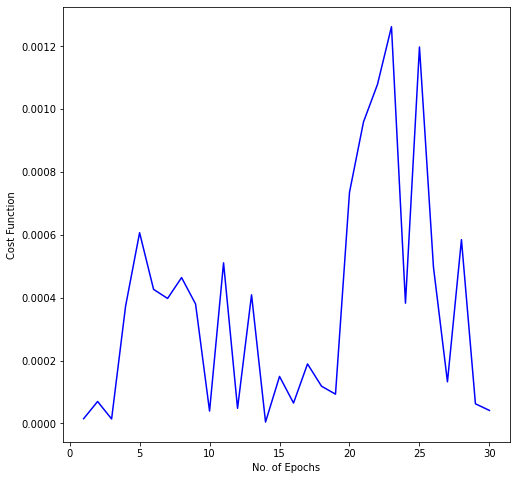

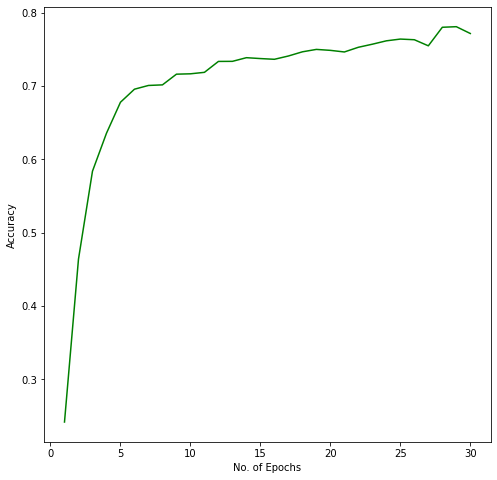

In [9]:
#-------------------------------------Plotting------------------------------------------

plot = plot_epoch
#Learning Curve
p = numpy.linspace(1,plot_epoch,plot_epoch)
fig = plt.figure(figsize=(8,8))
plt.plot(p, cost, 'b')
plt.xlabel('No. of Epochs')
plt.ylabel('Cost Function')
plt.show()
#Performance Curve
p = numpy.linspace(1,plot_epoch,plot_epoch)
fig = plt.figure(figsize=(8,8))
plt.plot(p, accuracy, 'g')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.show()

